# LLaDA Inference Profiling on HumanEval

This notebook runs inference on the LLaDA model using the HumanEval dataset and collects statistics for profiling.

## Load Model and Dataset

In [ ]:
import os
import subprocess
import torch
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset

os.environ['HF_HOME'] = '/root/LLaDA/hf_models/'
from transformers import AutoTokenizer, AutoModel

from generate import generate

# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Load Model and Tokenizer
model_id = 'GSAI-ML/LLaDA-8B-Instruct'
cache_path = '/root/LLaDA/hf_models/hub'

print(f"Loading model: {model_id}")
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True, cache_dir=cache_path, local_files_only=True)
model = AutoModel.from_pretrained(model_id, trust_remote_code=True, torch_dtype=torch.bfloat16, cache_dir=cache_path, local_files_only=True).to(device).eval()

# Ensure padding side is left for generation
if tokenizer.padding_side != 'left':
    tokenizer.padding_side = 'left'

print(model)

Using device: cuda
Loading model: GSAI-ML/LLaDA-8B-Instruct


/root/miniconda3/lib/python3.12/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

In [3]:
# Load HumanEval Dataset
print("Loading HumanEval dataset...")
dataset_path = '/root/LLaDA/hf_models/datasets/openai_humaneval'
ds = load_dataset(path=dataset_path, split="test")
print(f"Loaded {len(ds)} problems.")

# Display a sample
print("\nSample Problem:")
print(ds[0]['prompt'])


Loading HumanEval dataset...
Loaded 164 problems.

Sample Problem:
from typing import List


def has_close_elements(numbers: List[float], threshold: float) -> bool:
    """ Check if in given list of numbers, are any two numbers closer to each other than
    given threshold.
    >>> has_close_elements([1.0, 2.0, 3.0], 0.5)
    False
    >>> has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0, 2.0], 0.3)
    True
    """



## Run Model Inference and Collect Statistics

In [14]:
import torch.nn.functional as F

def add_gumbel_noise(logits, temperature):
    '''
    The Gumbel max is a method for sampling categorical distributions.
    According to arXiv:2409.02908, for MDM, low-precision Gumbel Max improves perplexity score but reduces generation quality.
    Thus, we use float64.
    '''
    if temperature == 0:
        return logits
    logits = logits.to(torch.float64)
    noise = torch.rand_like(logits, dtype=torch.float64)
    gumbel_noise = (- torch.log(noise)) ** temperature
    return logits.exp() / gumbel_noise


def get_num_transfer_tokens(mask_index, steps):
    '''
    In the reverse process, the interval [0, 1] is uniformly discretized into steps intervals.
    Furthermore, because LLaDA employs a linear noise schedule (as defined in Eq. (8)),
    the expected number of tokens transitioned at each step should be consistent.

    This function is designed to precompute the number of tokens that need to be transitioned at each step.
    '''
    mask_num = mask_index.sum(dim=1, keepdim=True)

    base = mask_num // steps
    remainder = mask_num % steps

    num_transfer_tokens = torch.zeros(mask_num.size(0), steps, device=mask_index.device, dtype=torch.int64) + base

    for i in range(mask_num.size(0)):
        num_transfer_tokens[i, :remainder[i]] += 1

    return num_transfer_tokens


class ActivationProfiler:
    def __init__(self, model, target_layers=['k_proj', 'v_proj', 'o_proj'], save_dir='../autodl-tmp/profiling_results'):
        self.model = model
        self.target_layers = target_layers
        self.hooks = []
        self.save_dir = save_dir
        self.current_step = 0
        self.buffer = {} # name -> tensor
        os.makedirs(self.save_dir, exist_ok=True)

    def register_hooks(self):
        self.clear()
        for name, module in self.model.named_modules():
            # Check if the module name ends with any of the target layers
            if any(name.endswith(t) for t in self.target_layers):
                # We only want leaf modules, usually
                hook = module.register_forward_hook(self.get_hook(name))
                self.hooks.append(hook)
        print(f"Registered hooks on {len(self.hooks)} layers.")

    def get_hook(self, name):
        def hook(module, input, output):
            # output shape: [batch, seq_len, hidden_dim]
            # Buffer to CPU memory instead of saving immediately to avoid I/O crashes
            self.buffer[name] = output.detach().cpu()
        return hook
    
    def step(self, current_step_index):
        """Sets the current step index for saving."""
        self.current_step = current_step_index

    def save_buffer(self):
        """Saves buffered tensors to disk sequentially."""
        if not self.buffer:
            return
            
        # Create a directory for the current step
        step_dir = os.path.join(self.save_dir, f"step_{self.current_step}")
        os.makedirs(step_dir, exist_ok=True)
        
        for name, tensor in self.buffer.items():
            # Replace dots with underscores for safe filenames
            safe_name = name.replace('.', '_')
            file_path = os.path.join(step_dir, f"{safe_name}.pt")
            torch.save(tensor, file_path)
        
        # Clear buffer to free memory
        self.buffer = {}

    def clear(self):
        for h in self.hooks:
            h.remove()
        self.hooks = []
        self.buffer = {}
        self.current_step = 0
        
    def get_collected_data(self):
        return self.save_dir


@ torch.no_grad()
def profiled_generate(model, prompt, attention_mask=None, steps=128, gen_length=128, block_length=128, temperature=0.,
             cfg_scale=0., remasking='low_confidence', mask_id=126336, logits_eos_inf=False, confidence_eos_eot_inf=False, profiler=None):
    '''
    Revised generate function adhering to generate.py logic with profiling.
    '''
    # Initialize x with mask
    x = torch.full((prompt.shape[0], prompt.shape[1] + gen_length), mask_id, dtype=torch.long).to(model.device)
    x[:, :prompt.shape[1]] = prompt.clone()

    if attention_mask is not None:
        attention_mask = torch.cat([attention_mask, torch.ones((prompt.shape[0], gen_length), dtype=attention_mask.dtype, device=model.device)], dim=-1)

    prompt_index = (x != mask_id)

    assert gen_length % block_length == 0
    num_blocks = gen_length // block_length

    assert steps % num_blocks == 0
    steps = steps // num_blocks

    # Profiling data storage
    step_details = []
    
    # Print inference statistics
    print(f'Generation length: {gen_length}')
    print(f'Denoising steps per block: {steps}')
    print(f'Number of blocks: {num_blocks}')

    # Helper for CUDA synchronization
    def synchronize():
        if x.device.type == 'cuda':
            torch.cuda.synchronize()

    synchronize()
    total_start = time.perf_counter()
    for num_block in range(num_blocks):
        block_mask_index = (x[:, prompt.shape[1] + num_block * block_length: prompt.shape[1] + (num_block + 1) * block_length:] == mask_id)
        num_transfer_tokens = get_num_transfer_tokens(block_mask_index, steps)
        
        for i in range(steps):
            global_step = num_block * steps + i
            if profiler:
                # print(f"flag step: global={global_step} block={num_block} in_block={i}")
                profiler.step(global_step)
            
            synchronize()
            step_start = time.perf_counter()
            
            mask_index = (x == mask_id)
            
            # 1. Model Forward Pass
            t_forward_start = time.perf_counter()
            if cfg_scale > 0.:
                un_x = x.clone()
                un_x[prompt_index] = mask_id
                x_ = torch.cat([x, un_x], dim=0)
                if attention_mask is not None:
                    attention_mask_ = torch.cat([attention_mask, attention_mask], dim=0)
                logits = model(x_, attention_mask=attention_mask_).logits
                logits, un_logits = torch.chunk(logits, 2, dim=0)
                logits = un_logits + (cfg_scale + 1) * (logits - un_logits)
            else:
                logits = model(x, attention_mask=attention_mask).logits
            synchronize()
            t_forward_end = time.perf_counter()

            # Save buffered activations for this (global) step
            if profiler:
                profiler.save_buffer()

            if logits_eos_inf:
                logits[:, :, 126081] = -torch.inf

            # 2. Sampling
            t_sample_start = time.perf_counter()
            logits_with_noise = add_gumbel_noise(logits, temperature=temperature)
            x0 = torch.argmax(logits_with_noise, dim=-1) # b, l
            synchronize()
            t_sample_end = time.perf_counter()

            if confidence_eos_eot_inf:
                logits_with_noise[:, :, 126081] = logits[:, :, 126348] = -torch.inf

            # 3. Remasking Strategy
            t_remask_start = time.perf_counter()
            if remasking == 'low_confidence':
                p = F.softmax(logits, dim=-1)
                x0_p = torch.squeeze(
                    torch.gather(p, dim=-1, index=torch.unsqueeze(x0, -1)), -1) # b, l
            elif remasking == 'random':
                x0_p = torch.rand((x0.shape[0], x0.shape[1]), device=x0.device)
            else:
                raise NotImplementedError(remasking)

            x0_p[:, prompt.shape[1] + (num_block + 1) * block_length:] = -np.inf

            x0 = torch.where(mask_index, x0, x)
            confidence = torch.where(mask_index, x0_p, -np.inf)

            transfer_index = torch.zeros_like(x0, dtype=torch.bool, device=x0.device)
            for j in range(confidence.shape[0]):
                _, select_index = torch.topk(confidence[j], k=num_transfer_tokens[j, i])
                transfer_index[j, select_index] = True
            x[transfer_index] = x0[transfer_index]
            
            synchronize()
            t_remask_end = time.perf_counter()
            
            step_end = time.perf_counter()
            step_duration = step_end - step_start
            
            step_details.append({
                "block_idx": num_block,
                "step_idx": i,
                "duration": step_duration,
                "forward_time": t_forward_end - t_forward_start,
                "sampling_time": t_sample_end - t_sample_start,
                "remasking_time": t_remask_end - t_remask_start,
                "num_masks": mask_index.sum().item()
            })

    synchronize()
    total_end = time.perf_counter()
    
    return x, step_details


def run_inference(model, tokenizer, prompt_text, steps=64, gen_length=64, block_length=32, profiler=None):
    """
    Runs inference and measures wall time with detailed profiling.
    """
    # Prepare input
    messages = [{"role": "user", "content": prompt_text}]
    formatted_prompt = tokenizer.apply_chat_template(messages, add_generation_prompt=True, tokenize=False)
    
    inputs = tokenizer(formatted_prompt, return_tensors="pt", padding=True, add_special_tokens=False)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    
    # Measure time
    start_time = time.perf_counter()
    
    with torch.no_grad():
        out, step_details = profiled_generate(
            model, 
            input_ids,
            attention_mask=attention_mask,
            steps=steps, 
            gen_length=gen_length, 
            block_length=block_length, 
            temperature=0., 
            cfg_scale=0., 
            remasking='low_confidence',
            profiler=profiler
        )
    
    end_time = time.perf_counter()
    wall_time = end_time - start_time
    
    # Decode output
    generated_text = tokenizer.batch_decode(out[:, input_ids.shape[1]:], skip_special_tokens=True)[0]
    
    return generated_text, wall_time, step_details

In [16]:
# Run Inference on a Subset
num_samples = 1
results = []
all_step_details = []

# Initialize Profiler
tensor_dir = '/root/autodl-tmp/profiling_results'
profiler = ActivationProfiler(model, target_layers=['q_proj', 'k_proj', 'v_proj', 'attn_out'], save_dir=tensor_dir)

# Ensure hooks are cleared initially
profiler.clear()

print(f"Running inference on first {num_samples} samples...")

for i in range(num_samples):
    problem = ds[i]
    prompt = problem['prompt']
    task_id = problem['task_id']
    
    print(f"Processing {task_id}...")

	# Register hooks for this run
    profiler.register_hooks()

    try:
        # Using parameters from chat.py/generate.py examples
        output, duration, step_details = run_inference(
            model=model, 
            tokenizer=tokenizer, 
            prompt_text=prompt, 
            steps=128, 
            gen_length=128, 
            block_length=32,
            profiler=profiler
        )
        
        results.append({
            "task_id": task_id,
            "wall_time": duration,
            "output_length": len(output),
            "output": output
        })
        
		# Add task_id to each step detail
        for d in step_details:
            d['task_id'] = task_id
        all_step_details.extend(step_details)
        print(f"  Time: {duration:.4f}s")
    except Exception as e:
        print(f"  Error: {e}")
        import traceback
        traceback.print_exc()
    finally:
        # Remove hooks to free memory and prevent crashes in subsequent runs
        profiler.clear()

profiler.clear() # Remove hooks after done

df_results = pd.DataFrame(results)
df_steps = pd.DataFrame(all_step_details)

Running inference on first 1 samples...
Processing HumanEval/0...
Registered hooks on 128 layers.
Generation length: 128
Denoising steps per block: 32
Number of blocks: 4
  Time: 47.8410s
  Time: 47.8410s


## Statistics Analysis and Visualization

### Latency Analysis

Wall Time Statistics (seconds):
Mean Latency: 47.8410
Median Latency: 47.8410
Std Dev: nan
Min: 47.8410
Max: 47.8410
P95: 47.8410
P99: 47.8410


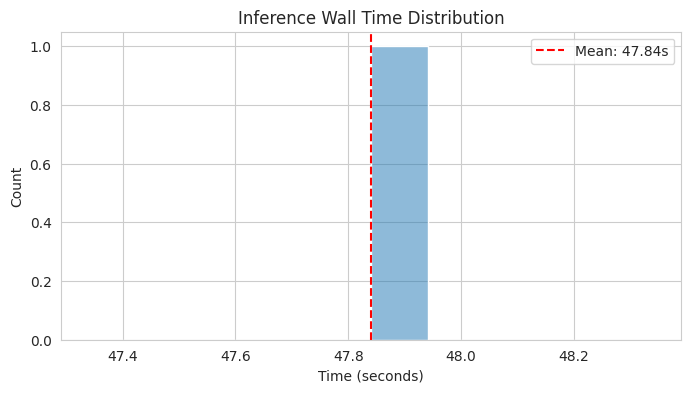


Breakdown (sum over all steps):
  forward_time: 20.3262s (99.5%)
  sampling_time: 0.0274s (0.1%)
  remasking_time: 0.0812s (0.4%)


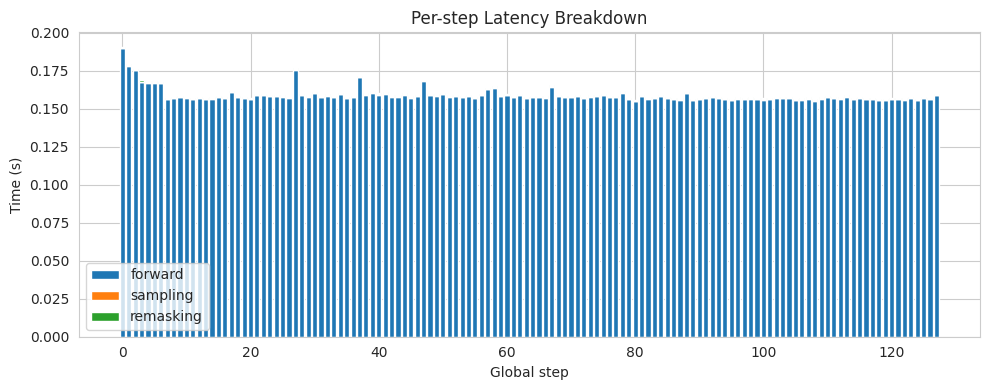

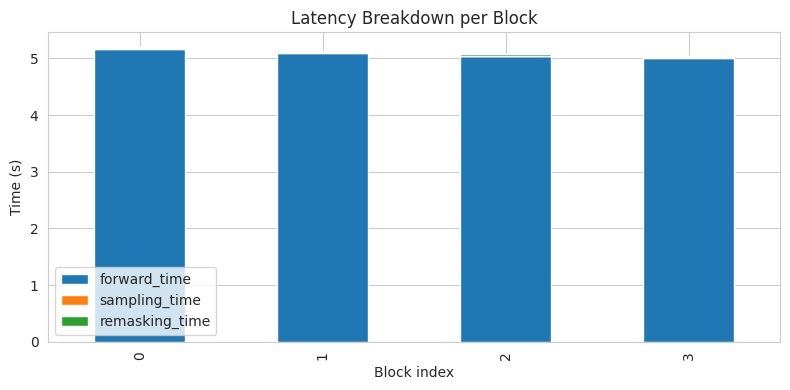

In [17]:
sns.set_style("whitegrid")

if not df_results.empty:
    # Wall-time stats
    stats = {
        "Mean Latency": df_results['wall_time'].mean(),
        "Median Latency": df_results['wall_time'].median(),
        "Std Dev": df_results['wall_time'].std(),
        "Min": df_results['wall_time'].min(),
        "Max": df_results['wall_time'].max(),
        "P95": df_results['wall_time'].quantile(0.95),
        "P99": df_results['wall_time'].quantile(0.99),
    }
    print("Wall Time Statistics (seconds):")
    for k, v in stats.items():
        print(f"{k}: {v:.4f}")

    plt.figure(figsize=(8, 4))
    sns.histplot(df_results['wall_time'], kde=True, bins=10)
    plt.title('Inference Wall Time Distribution')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Count')
    plt.axvline(df_results['wall_time'].mean(), color='r', linestyle='--', label=f"Mean: {df_results['wall_time'].mean():.2f}s")
    plt.legend()
    plt.show()

# Per-step breakdown
if not df_steps.empty:
    # Totals
    totals = df_steps[['forward_time', 'sampling_time', 'remasking_time']].sum()
    total_time = totals.sum()
    print("\nBreakdown (sum over all steps):")
    for name, val in totals.items():
        pct = 100.0 * val / total_time if total_time > 0 else 0.0
        print(f"  {name}: {val:.4f}s ({pct:.1f}%)")

    # Stacked bar per step
    plt.figure(figsize=(10, 4))
    steps_idx = np.arange(len(df_steps))
    fwd = df_steps['forward_time'].values
    smp = df_steps['sampling_time'].values
    rmk = df_steps['remasking_time'].values
    plt.bar(steps_idx, fwd, label='forward')
    plt.bar(steps_idx, smp, bottom=fwd, label='sampling')
    plt.bar(steps_idx, rmk, bottom=fwd + smp, label='remasking')
    plt.title('Per-step Latency Breakdown')
    plt.xlabel('Global step')
    plt.ylabel('Time (s)')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Optional: aggregate by block
    if 'block_idx' in df_steps.columns:
        block_agg = df_steps.groupby('block_idx')[['forward_time','sampling_time','remasking_time']].sum()
        block_agg.plot(kind='bar', stacked=True, figsize=(8,4), title='Latency Breakdown per Block')
        plt.xlabel('Block index')
        plt.ylabel('Time (s)')
        plt.tight_layout()
        plt.show()

### Tensor Distribution

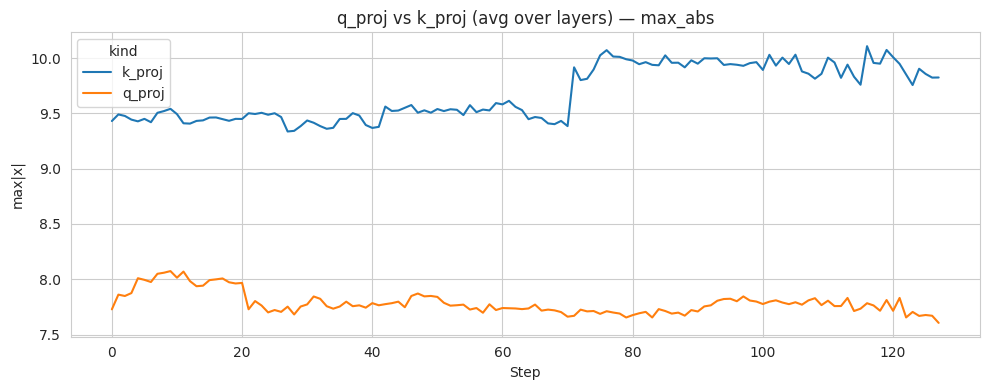

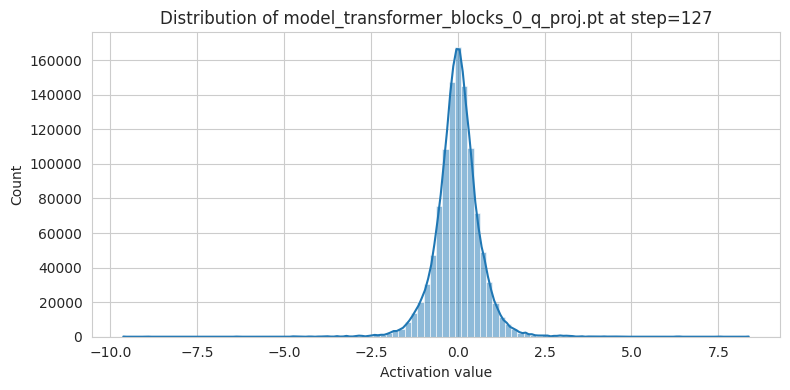

In [18]:
# =========================
# Tensor loader utilities (saved to disk during inference)
# =========================
import glob, re

def load_step_tensors(base_dir, step, selector_substrings):
    """
    Returns {layer_file: tensor} for files containing any selector substring.
    selector_substrings: list[str], e.g., ['q_proj', 'k_proj'].
    """
    step_dir = os.path.join(base_dir, f"step_{step}")
    tensors = {}
    if not os.path.isdir(step_dir):
        return tensors
    for f in glob.glob(os.path.join(step_dir, "*.pt")):
        base = os.path.basename(f)
        if any(s in base for s in selector_substrings):
            tensors[base] = torch.load(f, map_location="cpu")
    return tensors

_layer_re = re.compile(r".*layers_(\d+).*_(q_proj|k_proj|v_proj|attn_out|ff_proj|up_proj|ff_out)\.pt$")

def parse_layer_and_kind(layer_file_basename):
    """
    Extract (layer_idx:int, kind:str) from filename like 'model_layers_12_self_attn_q_proj.pt'.
    Returns (None, kind) if layer index not found.
    """
    m = _layer_re.match(layer_file_basename)
    if m:
        return int(m.group(1)), m.group(2)
    # Fallback: detect kind only
    for k in ['q_proj','k_proj','v_proj','attn_out','ff_proj','up_proj','ff_out']:
        if k in layer_file_basename:
            return None, k
    return None, None

def reduce_stat(t, how="mean_abs", sample=None):
    """
    Reduce a tensor [batch, seq, hidden] to a scalar.
    how: 'mean_abs' | 'max_abs' | 'std' | 'l2'
    sample: dict to subsample dims, e.g., {'seq': 256, 'hidden': 512}
    """
    x = t
    # optional subsample to reduce memory/plot time
    if sample:
        b, s, h = x.shape
        if 'seq' in sample:
            x = x[:, torch.linspace(0, s-1, steps=min(sample['seq'], s), dtype=torch.long), :]
        if 'hidden' in sample:
            x = x[:, :, torch.linspace(0, h-1, steps=min(sample['hidden'], h), dtype=torch.long)]
    x = x.float()
    if how == "mean_abs":
        return x.abs().mean().item()
    if how == "max_abs":
        return x.abs().amax().item()
    if how == "std":
        return x.std().item()
    if how == "l2":
        return x.pow(2).mean().sqrt().item()
    raise ValueError(how)

def collect_series(base_dir, selectors=('q_proj','k_proj'), how="mean_abs", sample=None, steps=None):
    """
    Scan steps->layers and compute a scalar stat per (step, layer, kind).
    Returns DataFrame columns: step, layer_idx, kind, value
    """
    rows = []
    # infer steps if not provided
    if steps is None:
        step_dirs = sorted([d for d in os.listdir(base_dir) if d.startswith("step_")],
                           key=lambda x: int(x.split('_')[1]))
        steps = [int(d.split('_')[1]) for d in step_dirs]
    for step in steps:
        tensors = load_step_tensors(base_dir, step, selectors)
        for name, t in tensors.items():
            layer_idx, kind = parse_layer_and_kind(name)
            if kind is None: 
                continue
            val = reduce_stat(t, how=how, sample=sample)
            rows.append({"step": step, "layer_idx": layer_idx, "kind": kind, "value": val, "name": name})
    return pd.DataFrame(rows)

# =========================
# Plots: evolution across layers and denoise steps
# =========================
# Example 1: Heatmap of mean_abs over (steps x layers) for q_proj
df_q = collect_series(tensor_dir, selectors=('q_proj',), how="mean_abs", sample={"seq":256, "hidden":512})
if not df_q.empty and df_q['layer_idx'].notna().all():
    pivot = df_q.pivot_table(index="step", columns="layer_idx", values="value", aggfunc="mean").sort_index()
    plt.figure(figsize=(12, 5))
    sns.heatmap(pivot.T, cmap="viridis", cbar_kws={"label": "mean|x|"}, robust=True)
    plt.title("q_proj mean_abs across layers (cols) and steps (rows)")
    plt.xlabel("Step")
    plt.ylabel("Layer index")
    plt.tight_layout()
    plt.show()

# Example 2: Compare q_proj vs k_proj averaged over layers per step
df_qk = collect_series(tensor_dir, selectors=('q_proj','k_proj'), how="max_abs", sample={"seq":256, "hidden":512})
if not df_qk.empty:
    df_avg = df_qk.groupby(['step','kind'])['value'].mean().reset_index()
    plt.figure(figsize=(10,4))
    sns.lineplot(data=df_avg, x='step', y='value', hue='kind')
    plt.title("q_proj vs k_proj (avg over layers) — max_abs")
    plt.xlabel("Step")
    plt.ylabel("max|x|")
    plt.tight_layout()
    plt.show()

# Example 3: Distribution at a given step for specific layers/kind
TARGET_STEP = df_q['step'].max() if not df_q.empty else None
if TARGET_STEP is not None:
    tensors = load_step_tensors(tensor_dir, TARGET_STEP, ['q_proj'])
    # pick first layer entry for demo
    if tensors:
        name, tensor = sorted(tensors.items())[0]
        x = tensor.float().view(-1).numpy()
        plt.figure(figsize=(8,4))
        sns.histplot(x, bins=100, kde=True)
        plt.title(f"Distribution of {name} at step={TARGET_STEP}")
        plt.xlabel("Activation value")
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()